#COVID XRAY CLASSIFICATION

In [0]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1741 (delta 69), reused 84 (delta 55), pack-reused 1616
Receiving objects: 100% (1741/1741), 221.08 MiB | 39.01 MiB/s, done.
Resolving deltas: 100% (843/843), done.
Checking out files: 100% (357/357), done.


In [0]:
import torch
import torchvision
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn,optim
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [0]:
data=pd.read_csv('/content/covid-chestxray-dataset/metadata.csv')
root_dir='/content/covid-chestxray-dataset/images/'


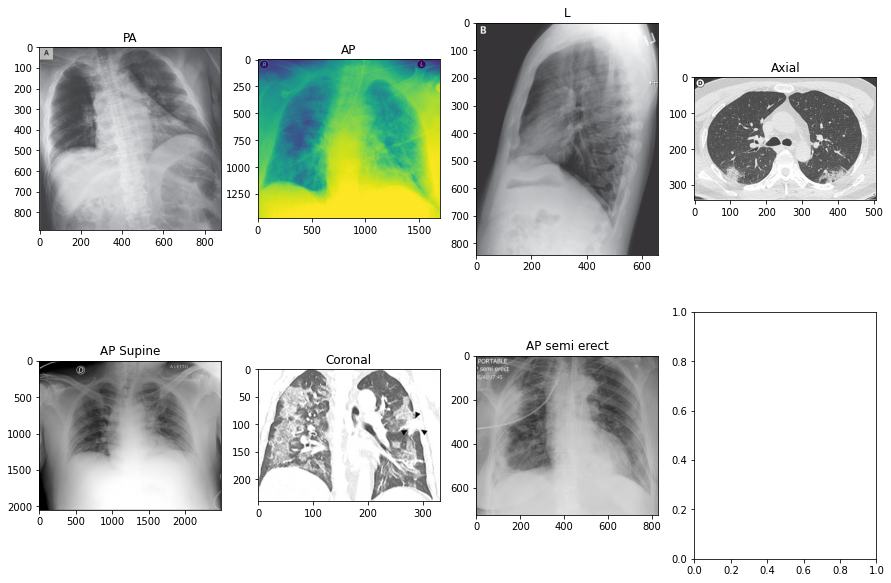

In [0]:
dif_views=data['view'].unique()
fig,axis=plt.subplots(2,4,figsize=(15,10))
images=[]
for view in dif_views:
  data_new=data[data['view']==view]
  data_new.reset_index(inplace=True)
  img_path=root_dir+data_new.loc[0,'filename']
  image=Image.open(img_path)
  images.append([view,image])
for i, ax in enumerate(axis.flat):
  ax.imshow(images[i][1]) # add image
  ax.set(title =images[i][0]) # add label
  if (i==6):
    break


In [0]:
data['view'].value_counts()

PA               194
AP                54
Axial             41
AP Supine         38
L                 29
Coronal            3
AP semi erect      1
Name: view, dtype: int64

In [0]:
data['finding'].value_counts()

COVID-19          284
Streptococcus      17
SARS               16
Pneumocystis       15
COVID-19, ARDS     12
E.Coli              4
ARDS                4
No Finding          3
Legionella          2
Chlamydophila       2
Klebsiella          1
Name: finding, dtype: int64

We are considering only PA view of X-Rays

In [0]:
data=data[data['view']=='PA']
data=data[data['folder']=='images']

In [0]:
data['finding'].value_counts()

COVID-19          140
Streptococcus      13
Pneumocystis       12
COVID-19, ARDS     11
SARS                8
ARDS                4
No Finding          2
Legionella          2
Klebsiella          1
Chlamydophila       1
Name: finding, dtype: int64

* The data is biased towards COVID samples
* So To make it balanced we are considering only half of the COVID-19 Samples

In [0]:
train_val_data,test_data=train_test_split(data[(data['finding']=='COVID-19')|(data['finding']=='COVID-19, ARDS')],test_size=0.5,random_state=56)
data.drop(test_data.index, inplace=True)
data.reset_index(inplace=True)

In [0]:
data['finding'].value_counts()

COVID-19          70
Streptococcus     13
Pneumocystis      12
SARS               8
COVID-19, ARDS     5
ARDS               4
No Finding         2
Legionella         2
Chlamydophila      1
Klebsiella         1
Name: finding, dtype: int64

* In the dataset the majority data is COVID-19.So this makes the model overfit COVID-19
* To avoid this what we do is make the dataset balanced.
* This can be done in the following way:
  * Make train dataset contains 50% of COVID images and remaining Non-Covid images


In [0]:
for i in data['filename'].values:
  if i.split('.')[-1]=='gz':
    print(i)

The below code creates a class based on Dataset class of torch
* We need to pass a dataframe,directory of images and transforms to be applied to the image
* The Dataframe should contain view,folder,filename and findings columns.

In [0]:
class MYDATASET(Dataset):
    def __init__(self, dataframe, root_dir,transform):
        self.data = data
        self.data=self.data[self.data['view']=='PA']
        self.data=self.data[self.data['folder']=='images']
        self.data.reset_index(inplace=True)
        self.finding=self.data.finding
        self.filename=self.data.filename
        self.root_dir = root_dir
        self.transform = transform
        
        
    def __len__(self):
        return len(self.filename)

    def __getitem__(self, idx):
        # take the image name contained in the csv file
        image_name = os.path.join(self.root_dir, self.filename[idx])
        image = Image.open(image_name).convert('RGB')
        image = np.array(image.resize((256,256)))
        image = image[:,:,0]
        image = np.uint8(((np.array(image)/255).reshape(256,256,1))*255*255)
        image = np.tile(image,3)
        
        label=(self.finding[idx]=='COVID-19') or (self.finding[idx]=='COVID-19, ARDS')        

        return self.transform(image),label
    


In [0]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                ])
csv_file='/content/covid-chestxray-dataset/metadata.csv'
root_dir='/content/covid-chestxray-dataset/images'
dataset=MYDATASET(data,root_dir,transform)

In [0]:
batch_size=16
valid_size=0.2

In [0]:
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
trainloader = torch.utils.data.DataLoader(dataset,
                   sampler=train_sampler, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(dataset,
                   sampler=test_sampler, batch_size=batch_size)

In [0]:
def round(values,threshold):
  for i in range(len(values)):
    if (values[i]<threshold):
      values[i]=0
    else:
      values[i]=1
  return values

In [0]:
model=torchvision.models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


In [0]:
model.fc=nn.Sequential(nn.Linear(1024,1),
                       nn.Sigmoid())

In [0]:
epochs=15
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
device=torch.cuda.is_available()

In [0]:
if device:
  model.cuda()
for e in range(1,epochs+1):
  train_loss=0
  model.train()
  count=0
  for images,labels in trainloader:
    optimizer.zero_grad()
    if device:
      images,labels=images.cuda(),labels.cuda()
    output=model(images)
    loss=criterion(output.view(-1),labels.view(-1).float())
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()
    count+=images.size(0)
  train_loss=train_loss/count

  total_targets=np.array([])
  total_outputs=np.array([])
  total_values=np.array([])
  model.eval()
  valid_loss=0
  count=0
  for images,labels in validloader:
    if device:
      images,labels=images.cuda(),labels.cuda()
    with torch.no_grad():
      output=model(images)
      #total_outputs=np.concatenate([total_outputs,torch.round(output).detach().cpu().view(-1).numpy()])
      total_targets=np.concatenate([total_targets,labels.cpu().view(-1).numpy()])
      total_values=np.concatenate([total_values,output.detach().cpu().view(-1).numpy()])
      loss=criterion(output.view(-1),labels.view(-1).float())
      valid_loss+=loss.item()
      count+=images.size(0)
  valid_loss=valid_loss/count
  print("---------------------------------------------------------------------------------------------------")
  print("Epoch {}/{}   Training loss : {}    Test Loss:  {}".format(e,epochs,train_loss,valid_loss))
  for i in [0.5]:
    print('-------------------------------------------')
    total_outputs=round(total_values,i)
    mat=confusion_matrix(total_targets,total_outputs)
    print("Threshold Value--",i)
    print(mat)
  print("ROC AUC SCORE=  ",roc_auc_score(np.array(total_targets),np.array(total_values)))

  path_for_model='model_epoch_'+str(e)+'.pt'
  torch.save(model.state_dict(),path_for_model)
    
    


  

---------------------------------------------------------------------------------------------------
Epoch 1/15   Training loss : 0.04464491543016936    Test Loss:  0.04381713400716367
-------------------------------------------
Threshold Value-- 0.5
[[ 4  3]
 [ 1 15]]
ROC AUC SCORE=   0.7544642857142856
---------------------------------------------------------------------------------------------------
Epoch 2/15   Training loss : 0.020862364768981935    Test Loss:  0.031768745054369385
-------------------------------------------
Threshold Value-- 0.5
[[ 5  2]
 [ 1 15]]
ROC AUC SCORE=   0.8258928571428571
---------------------------------------------------------------------------------------------------
Epoch 3/15   Training loss : 0.007782462552974098    Test Loss:  0.08400005102157593
-------------------------------------------
Threshold Value-- 0.5
[[ 6  1]
 [ 6 10]]
ROC AUC SCORE=   0.7410714285714286
----------------------------------------------------------------------------------

In [0]:
root_dir='/content/covid-chestxray-dataset/images'
testdataset=MYDATASET(test_data,root_dir,transform)

In [0]:
testloader=torch.utils.data.DataLoader(testdataset,batch_size=16)

In [0]:
len(testloader)

8

In [0]:
total_targets=np.array([])
total_outputs=np.array([])
total_values=np.array([])
model.eval()
test_loss=0
count=0
for images,labels in testloader:
  if device:
    images,labels=images.cuda(),labels.cuda()
  with torch.no_grad():
    output=model(images)
    total_outputs=np.concatenate([total_outputs,torch.round(output).detach().cpu().view(-1).numpy()])
    total_targets=np.concatenate([total_targets,labels.cpu().view(-1).numpy()])
    total_values=np.concatenate([total_values,output.detach().cpu().view(-1).numpy()])
    loss=criterion(output.view(-1),labels.view(-1).float())
    test_loss+=loss.item()
    count+=images.size(0)
test_loss=test_loss/count
print("Test Loss:  {}".format(test_loss))
mat=confusion_matrix(total_targets,total_outputs)
print(mat)
print("ROC AUC SCORE=  ",roc_auc_score(np.array(total_targets),np.array(total_values)))


Test Loss:  0.008058613407429529
[[39  4]
 [ 0 75]]
ROC AUC SCORE=   0.9910077519379845


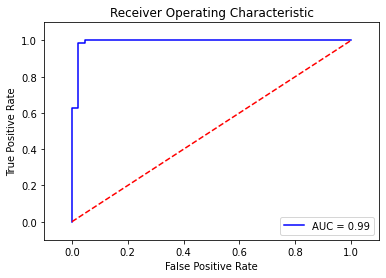

In [0]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(total_targets, total_values)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
iterator=iter(testloader)
images,labels=next(iterator)

In [0]:
with torch.no_grad():
  images=images.cuda()
  output=model(images)
  output=torch.round(output).detach().squeeze().cpu()
  print(output)

tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.])


In [0]:
print(labels)

tensor([ True,  True, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True])


In [0]:

def display_img(image):
    image=image.cpu()
    image=image.squeeze().numpy()
    image=image.transpose((1,2,0))
    image=image* np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image=np.clip(image,0,1)
    return image


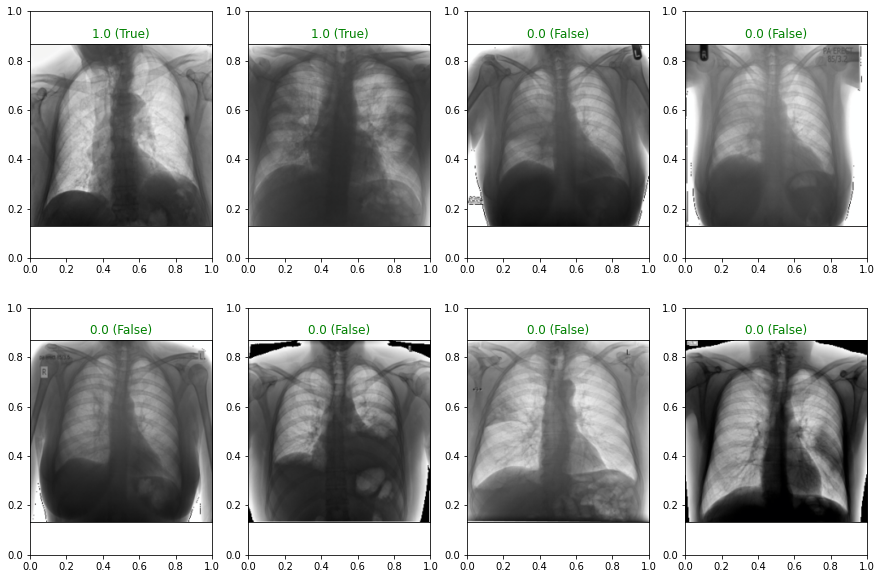

In [0]:
fig,ax = plt.subplots(2,4,figsize=(15, 10))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(display_img(images[idx]))
    ax.set_title("{} ({})".format(str(output[idx].item()), str(labels[idx].item())),
                 color=("green" if output[idx]==labels[idx] else "red"))

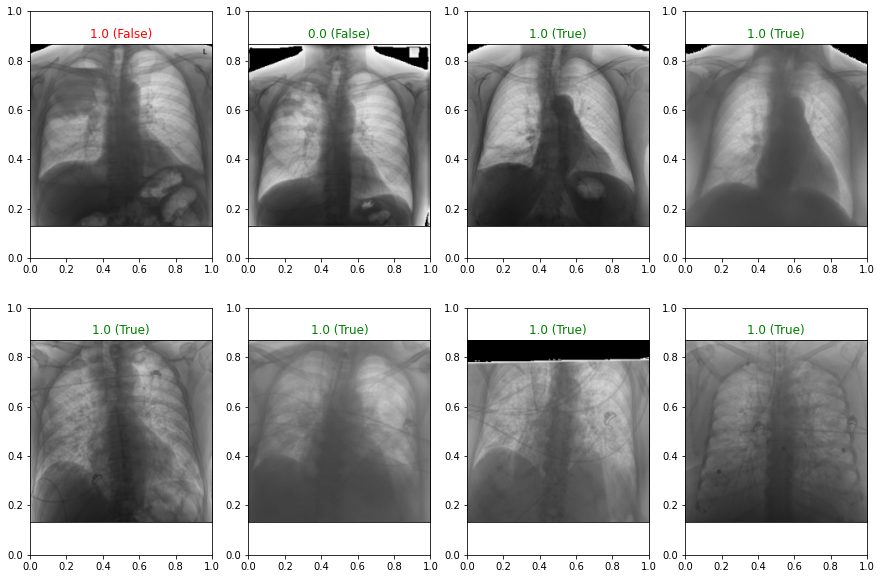

In [0]:
fig,ax = plt.subplots(2,4,figsize=(15, 10))
for idx in np.arange(8,16):
    ax = fig.add_subplot(2, 4, idx-8+1, xticks=[], yticks=[])
    ax.imshow(display_img(images[idx]))
    ax.set_title("{} ({})".format(str(output[idx].item()), str(labels[idx].item())),
                 color=("green" if output[idx]==labels[idx] else "red"))